# AI-based OCR Benchmark Notebook

This notebook benchmarks **AI-based OCR models** on scanned PDF documents/images in Spanish.
It excludes traditional OCR engines like Tesseract that require external installations.

In [ ]:
%pip install --upgrade pip
%pip install --upgrade jupyter
%pip install --upgrade ipywidgets
%pip install --upgrade ipykernel

# Install necessary packages
%pip install transformers torch pdf2image pillow jiwer paddleocr hf_xet paddlepaddle
# pdf reading
%pip install PyMuPDF

# Data analysis and visualization
%pip install pandas
%pip install matplotlib
%pip install seaborn

In [1]:
# Imports
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image, ImageOps
import torch
from jiwer import wer, cer
from paddleocr import PaddleOCR
import fitz  # PyMuPDF
import re
from datetime import datetime

## 1 Configuration

In [2]:
PDF_FOLDER = './instructions'  # Folder containing PDF files
OUTPUT_FOLDER = 'results'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [3]:
PDF_FOLDER_ABS = os.path.abspath(PDF_FOLDER)              # ./instructions -> C:\...\instructions
SCRIPT_ABS = os.path.abspath("paddle_ocr_tuning.py")      # paddle_ocr_tuning.py -> C:\...\paddle_ocr_tuning.py
SCRIPT_DIR = os.path.dirname(SCRIPT_ABS)

print(PDF_FOLDER_ABS)
print(SCRIPT_ABS)
print(SCRIPT_DIR)

c:\Users\sji\Desktop\MastersThesis\instructions
c:\Users\sji\Desktop\MastersThesis\paddle_ocr_tuning.py
c:\Users\sji\Desktop\MastersThesis


In [ ]:
# 3. PaddleOCR 
# https://www.paddleocr.ai/v3.0.0/en/version3.x/pipeline_usage/OCR.html?utm_source=chatgpt.com#21-command-line
from paddleocr import PaddleOCR

# Initialize with better settings for Spanish/Latin text
# https://www.paddleocr.ai/main/en/version3.x/algorithm/PP-OCRv5/PP-OCRv5_multi_languages.html?utm_source=chatgpt.com#5-models-and-their-supported-languages
paddleocr_model = PaddleOCR(
    text_detection_model_name="PP-OCRv5_server_det",
    text_recognition_model_name="PP-OCRv5_server_rec"
)

In [9]:
import paddleocr

print(paddleocr.__version__)

3.3.1

In [10]:
# 1) Locate the installed PaddleOCR package
pkg_dir = os.path.dirname(paddleocr.__file__)
print(pkg_dir)

c:\Users\sji\Desktop\MastersThesis\.venv\Lib\site-packages\paddleocr

## 2 Helper Functions

In [ ]:
from typing import List, Optional
from paddle_ocr_tuning import pdf_to_images, pdf_extract_text, evaluate_text, assemble_from_paddle_result

def show_page(img: Image.Image, text: str,  scale: float = 1):
    """
    Displays a smaller version of the image with text as a footer.
    """
    # Compute plot size based on image dimensions (but without resizing the image)
    w, h = img.size
    figsize = (w * scale / 100, h * scale / 100)  # convert pixels to inches approx

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.axis("off")


    # Add OCR text below the image (footer)
    # plt.figtext(0.5, 0.02, text.strip(), wrap=True, ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

## Run AI OCR Benchmark

In [ ]:
results = []

for pdf_file in os.listdir(PDF_FOLDER):
    if not pdf_file.lower().endswith('.pdf'):
        continue
    pdf_path = os.path.join(PDF_FOLDER, pdf_file)
    page_range = range(5, 10)
    
    images = pdf_to_images(pdf_path, 300, page_range)
    
    for i, img in enumerate(images):
        # img = preprocess_for_ocr(img)
        page_num = page_range[i]
        ref = pdf_extract_text(pdf_path, page_num=page_num)
        show_page(img, f"page: {page_num}", 0.15)
        print(f"ref: \n{ref}")
        
        # Convert PIL image to numpy array
        image_array = np.array(img)
        out = paddleocr_model.predict(
                image_array,
                use_doc_orientation_classify=False,
                use_doc_unwarping=False,
                use_textline_orientation=True
            )
        # PaddleOCR
        paddle_text = assemble_from_paddle_result(out)
        print(f"paddle_text: \n{paddle_text}")
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'PaddleOCR', 'Prediction': paddle_text, **evaluate_text(ref, paddle_text)})
        

## 5 Save and Analyze Results

In [ ]:
df_results = pd.DataFrame(results)

# Generate a unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"ai_ocr_benchmark_finetune_results_{timestamp}.csv"
filepath = os.path.join(OUTPUT_FOLDER, filename)

df_results.to_csv(filepath, index=False)
print(f"Benchmark results saved as {filename}")

# Summary by model
summary = df_results.groupby('Model')[['WER', 'CER']].mean()
print(summary)

# Plot
summary.plot(kind='bar', figsize=(8,5), title='AI OCR Benchmark (WER & CER)')
plt.ylabel('Error Rate')
plt.show()

### How to read this chart:
- CER (Character Error Rate) focus on raw transcription quality
- WER (Word Error Rate) penalizes incorrect tokenization or missing spaces
- CER and WER are error metrics, which means:
    - Higher values = worse performance
    - Lower values = better accuracy

# Busqueda de hyperparametros
https://docs.ray.io/en/latest/tune/index.html

In [ ]:
!python --version
!pip --version

In [18]:
# Instalación de Ray y Ray Tune
%pip install -U "ray[tune]" rich

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ---------------------------------------- 0/3 [mdurl]
   ------------- -------------------------- 1/3 [markdown-it-py]
   ------------- -------------------------- 1/3 [markdown-it-py]
   ------------- -------------------------- 1/3 [markdown-it-py]
   ------------- -------------------------- 1/3 [markdown-it-py]
   ------------- -------------------------- 1/3 [markdown-it-py]
   ------------- ------------------------

In [6]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler

ray.init(ignore_reinit_error=True)
print("Ray Tune listo (versión:", ray.__version__, ")")

2025-11-12 22:30:42,267	INFO worker.py:1850 -- Calling ray.init() again after it has already been called.


Ray Tune listo (versión: 2.51.1 )


In [7]:
# ===============================================================
# 🔍 RAY TUNE: OPTIMIZACIÓN AUTOMÁTICA DE HIPERPARÁMETROS OCR
# ===============================================================

from ray import tune, air
from ray.tune.schedulers import ASHAScheduler
import pandas as pd
import time
import colorama
from rich import print
import sys, subprocess 
from rich.console import Console

colorama.just_fix_windows_console()
ray.init(ignore_reinit_error=True)

# Tell Ray Tune to use a Jupyter-compatible console
console = Console(force_jupyter=True)

2025-11-12 22:30:48,318	INFO worker.py:1850 -- Calling ray.init() again after it has already been called.


In [8]:


# --- Configuración base del experimento ---
search_space = {
    "dpi": tune.choice([240, 300, 360]),
    "textline_orientation": tune.choice([True, False]),
    "text_det_box_thresh": tune.uniform(0.4, 0.7),
    "text_det_unclip_ratio": tune.uniform(1.2, 2.0),
    "text_rec_score_thresh": tune.choice([0.0, 0.2, 0.4]),
    "line_tolerance": tune.choice([0.5, 0.6, 0.7]),
    "min_box_score": tune.choice([0, 0.5, 0.6])
}
KEYMAP = {
    "dpi": "dpi",
    "textline_orientation": "textline-orientation",
    "text_det_box_thresh": "text-det-box-thresh",
    "text_det_unclip_ratio": "text-det-unclip-ratio",
    "text_rec_score_thresh": "text-rec-score-thresh",
    "line_tolerance": "line-tolerance",
    "pages_per_pdf": "pages-per-pdf",
    "min_box_score": "min-box-score",
}

In [7]:
import sys, subprocess
print("Notebook Python:", sys.executable)
# test paddle ocr run with params
args = [sys.executable, 
        SCRIPT_ABS, 
        "--pdf-folder", PDF_FOLDER_ABS, 
        "--pages-per-pdf", "1",
        "--dpi","360" ,
        "--textline-orientation","True",
        "--text-det-box-thresh","0.46611732611383844",
        "--text-det-unclip-ratio","1.3598680409827462",
        "--text-rec-score-thresh","0.0",
        "--line-tolerance", "0.5",
        "--min-box-score","0.6"]
test_proc = subprocess.run(args, capture_output=True, text=True, cwd=SCRIPT_DIR)
if test_proc.returncode != 0:
        print(test_proc.stderr)
last = test_proc.stdout.strip().splitlines()[-1]

metrics = json.loads(last)
print(metrics)

print(f"return code: {test_proc.returncode}")
print(f"args: {args}")

Notebook Python: c:\Users\sji\Desktop\MastersThesis\.venv\Scripts\python.exe

{'CER': 0.019801980198019802, 'WER': 0.09090909090909091, 'TIME': 38.859522104263306, 'PAGES': 1}

return code: 0

args: ['c:\\Users\\sji\\Desktop\\MastersThesis\\.venv\\Scripts\\python.exe', 
'c:\\Users\\sji\\Desktop\\MastersThesis\\paddle_ocr_tuning.py', '--pdf-folder', 
'c:\\Users\\sji\\Desktop\\MastersThesis\\instructions', '--pages-per-pdf', '1', '--dpi', '360', 
'--textline-orientation', 'True', '--text-det-box-thresh', '0.46611732611383844', '--text-det-unclip-ratio', 
'1.3598680409827462', '--text-rec-score-thresh', '0.0', '--line-tolerance', '0.5', '--min-box-score', '0.6']

In [9]:
def trainable_paddle_ocr(config):
    args = [sys.executable, SCRIPT_ABS, "--pdf-folder", PDF_FOLDER_ABS, "--pages-per-pdf", "2"]
    for k, v in config.items():
        args += [f"--{KEYMAP[k]}", str(v)]
    proc =  subprocess.run(args, capture_output=True, text=True, cwd=SCRIPT_DIR)

    if proc.returncode != 0:
        tune.report(CER=1.0, WER=1.0, TIME=0.0, ERROR=proc.stderr[:500])
        return
    # última línea = JSON con métricas
    last = proc.stdout.strip().splitlines()[-1]
    
    metrics = json.loads(last)
    tune.report(metrics=metrics)

scheduler = ASHAScheduler(grace_period=1, reduction_factor=2)

tuner = tune.Tuner(
    trainable_paddle_ocr,
    tune_config=tune.TuneConfig(metric="CER", 
                                mode="min", 
                                scheduler=scheduler, 
                                num_samples=2, 
                                max_concurrent_trials=4),
    run_config=air.RunConfig(verbose=2, log_to_file=False),
    param_space=search_space
)

results = tuner.fit()



c:\Users\sji\Desktop\MastersThesis\.venv\Lib\site-packages\ray\tune\impl\tuner_internal.py:144: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
2025-11-12 22:31:01,166	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-11-12 22:31:01,216	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\sji\AppData\Local\Temp\ray\session_2025-11-12_22-29-00_496141_15712\artifacts\2025-11-12_22-31-01\trainable_paddle_ocr_2025-11-12_22-31-01\driver_artifacts\trainable_paddle_ocr_3632f_00000_0_dpi=360,line_tolerance=0.6000,min_box_score=0.6000,text_det_box_thresh=0.5981,text_det_unclip_r_2025-11-12_22-31-01
2025-11-12 22:31:01,216	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\sji\AppData\Local\Temp\ray\session_2025-11-12_22-29-00_496141_15712\artifacts\2025-11-12_22-31-01\trainable_paddle_ocr_2025-11-12_22-31-01\driver_artifacts\trainable_paddle_ocr_3632f_00000_0_dpi=360,line_tolerance=0.6000,min_box_score=0.6000,text_det_box_thresh=0.5981,text_det_unclip_r_2025-11-12_22-31-01
2025-11-

2025-11-12 22:38:52,093	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\sji\AppData\Local\Temp\ray\session_2025-11-12_22-29-00_496141_15712\artifacts\2025-11-12_22-31-01\trainable_paddle_ocr_2025-11-12_22-31-01\driver_artifacts\trainable_paddle_ocr_3632f_00001_1_dpi=300,line_tolerance=0.6000,min_box_score=0.5000,text_det_box_thresh=0.4181,text_det_unclip_r_2025-11-12_22-31-01
2025-11-12 22:39:26,972	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\sji\AppData\Local\Temp\ray\session_2025-11-12_22-29-00_496141_15712\artifacts\2025-11-12_22-31-01\trainable_paddle_ocr_2025-11-12_22-31-01\driver_artifacts\trainable_paddle_ocr_3632f_00000_0_dpi=360,line_tolerance=0.6000,min_box_score=0.6000,text_det_box_thresh=0.5981,text_det_unclip_r_2025-11-12_22-31-01
2025-11-

In [10]:
df = results.get_dataframe().sort_values("CER", ascending=True)

In [11]:
# Generate a unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"raytune_paddle_subproc_results_{timestamp}.csv"
filepath = os.path.join(OUTPUT_FOLDER, filename)


df.to_csv(filename, index=False)
print(f"Guardado: {filename}")

Guardado: raytune_paddle_subproc_results_20251112_223927.csv

In [12]:
df.describe()

CER       WER        TIME  PAGES  TIME_PER_PAGE     timestamp  \
count  2.000000  2.000000    2.000000    2.0       2.000000  2.000000e+00   
mean   0.062383  0.350325  456.315870    2.0     228.070288  1.762958e+09   
std    0.008594  0.091373   24.641709    0.0      12.300573  2.404163e+01   
min    0.056306  0.285714  438.891550    2.0     219.372469  1.762958e+09   
25%    0.059345  0.318019  447.603710    2.0     223.721378  1.762958e+09   
50%    0.062383  0.350325  456.315870    2.0     228.070288  1.762958e+09   
75%    0.065421  0.382630  465.028030    2.0     232.419197  1.762958e+09   
max    0.068460  0.414935  473.740190    2.0     236.768107  1.762958e+09   

       training_iteration  time_this_iter_s  time_total_s           pid  \
count                 2.0          2.000000      2.000000      2.000000   
mean                  1.0        482.937319    482.937319  16592.000000   
std                   0.0         24.696451     24.696451   8196.781808   
min                   1.0        465.474291    465.474291  10796.000000   
25%                   1.0        474.205805    474.205805  13694.000000   
50%                   1.0        482.937319    482.937319  16592.000000   
75%                   1.0        491.668833    491.668833  19490.000000   
max                   1.0        500.400347    500.400347  22388.000000   

       time_since_restore  iterations_since_restore  config/dpi  \
count            2.000000                       2.0    2.000000   
mean           482.937319                       1.0  330.000000   
std             24.696451                       0.0   42.426407   
min            465.474291                       1.0  300.000000   
25%            474.205805                       1.0  315.000000   
50%            482.937319                       1.0  330.000000   
75%            491.668833                       1.0  345.000000   
max            500.400347                       1.0  360.000000   

       config/text_det_box_thresh  config/text_det_unclip_ratio  \
count                    2.000000                      2.000000   
mean                     0.508104                      1.606787   
std                      0.127329                      0.016666   
min                      0.418069                      1.595003   
25%                      0.463086                      1.600895   
50%                      0.508104                      1.606787   
75%                      0.553121                      1.612680   
max                      0.598139                      1.618572   

       config/text_rec_score_thresh  config/line_tolerance  \
count                           2.0                    2.0   
mean                            0.2                    0.6   
std                             0.0                    0.0   
min                             0.2                    0.6   
25%                             0.2                    0.6   
50%                             0.2                    0.6   
75%                             0.2                    0.6   
max                             0.2                    0.6   

       config/min_box_score  
count              2.000000  
mean               0.550000  
std                0.070711  
min                0.500000  
25%                0.525000  
50%                0.550000  
75%                0.575000  
max                0.600000

In [16]:
param_cols = [
    "config/dpi",
    "config/text_det_box_thresh",
    "config/text_det_unclip_ratio",
    "config/text_rec_score_thresh",
    "config/line_tolerance",
    "config/min_box_score",
]
# Correlación de Pearson con CER y WER
corr_cer = df[param_cols + ["CER"]].corr()["CER"].sort_values(ascending=False)
corr_wer = df[param_cols + ["WER"]].corr()["WER"].sort_values(ascending=False)

print("Correlación con CER:\n", corr_cer)
print("Correlación con WER:\n", corr_wer)

Correlación con CER:
 config/min_box_score            1.0
CER                             1.0
config/text_det_box_thresh      1.0
config/dpi                      1.0
config/text_det_unclip_ratio   -1.0
config/text_rec_score_thresh    NaN
config/line_tolerance           NaN
Name: CER, dtype: float64

Correlación con WER:
 config/min_box_score            1.0
config/dpi                      1.0
config/text_det_box_thresh      1.0
WER                             1.0
config/text_det_unclip_ratio   -1.0
config/text_rec_score_thresh    NaN
config/line_tolerance           NaN
Name: WER, dtype: float64

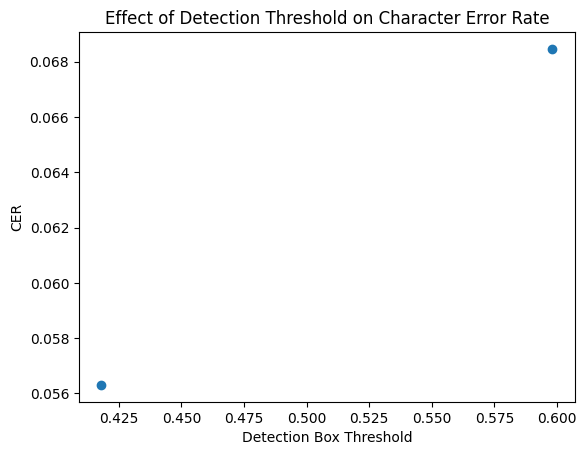

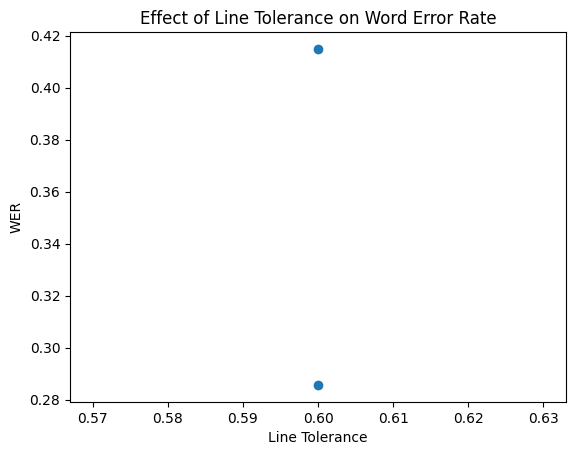

In [13]:
import matplotlib.pyplot as plt

plt.scatter(df["config/text_det_box_thresh"], df["CER"])
plt.xlabel("Detection Box Threshold")
plt.ylabel("CER")
plt.title("Effect of Detection Threshold on Character Error Rate")
plt.show()

plt.scatter(df["config/line_tolerance"], df["WER"])
plt.xlabel("Line Tolerance")
plt.ylabel("WER")
plt.title("Effect of Line Tolerance on Word Error Rate")
plt.show()
